<a href="https://colab.research.google.com/github/dhyannn/Deep-learning/blob/main/514_DLprog2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load data
data_path = '/content/drive/MyDrive/archive/simulated-data-raw-main/data'
df = pd.DataFrame()
files = 0

import os
for x in os.listdir(data_path):
    df = pd.concat([df, pd.read_pickle(os.path.join(data_path, x))], axis=0, ignore_index=True)
    files += 1

print(f'Files Processed: {files}')

Files Processed: 183


In [2]:
df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,9488,2018-04-02 00:00:11,2221,6047,21.24,86411,1,0,0
1,9489,2018-04-02 00:01:08,3535,2848,60.47,86468,1,0,0
2,9490,2018-04-02 00:01:16,4974,313,75.04,86476,1,0,0
3,9491,2018-04-02 00:01:27,4259,5014,27.93,86487,1,0,0
4,9492,2018-04-02 00:01:48,2896,4117,82.06,86508,1,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1562388,2018-09-10 23:58:24,893,6456,9.86,14083104,162,1,2
1754151,1562389,2018-09-10 23:58:51,3855,8786,87.35,14083131,162,0,0
1754152,1562390,2018-09-10 23:59:02,699,4003,81.72,14083142,162,0,0
1754153,1562391,2018-09-10 23:59:08,3792,2151,61.95,14083148,162,0,0


In [22]:
from datetime import date, datetime, timedelta
import os
import math
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve

In [4]:
not_fraud_count, fraud_count = np.bincount(df['TX_FRAUD'])

total_count = not_fraud_count + fraud_count
print(
    (
        f"Data:\n"
        f"Total: {total_count}\n"
        f"Fraud: {fraud_count} ({100 * fraud_count / total_count:.2f}% of total)\n"
    )
)

Data:
Total: 1754155
Fraud: 14681 (0.84% of total)



In [5]:
df = pd.concat(
    [
        df[df['TX_FRAUD'] == 0].sample(1000, random_state=14),
        df[df['TX_FRAUD'] == 1].sample(1000, random_state=14)
    ]
)

In [6]:
df.shape

(2000, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 98114 to 1596862
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TRANSACTION_ID     2000 non-null   int64         
 1   TX_DATETIME        2000 non-null   datetime64[ns]
 2   CUSTOMER_ID        2000 non-null   object        
 3   TERMINAL_ID        2000 non-null   object        
 4   TX_AMOUNT          2000 non-null   float64       
 5   TX_TIME_SECONDS    2000 non-null   object        
 6   TX_TIME_DAYS       2000 non-null   object        
 7   TX_FRAUD           2000 non-null   int64         
 8   TX_FRAUD_SCENARIO  2000 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 156.2+ KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TRANSACTION_ID,2000.0,905426.45450,488932.568021,704.00,492622.500,904333.000,1331973.000,1754014.0
TX_AMOUNT,2000.0,88.24043,113.214883,0.08,23.625,53.045,100.385,939.9
TX_FRAUD,2000.0,0.50000,0.500125,0.00,0.000,0.500,1.000,1.0
TX_FRAUD_SCENARIO,2000.0,1.13650,1.204406,0.00,0.000,0.500,2.000,3.0


In [9]:
df.isnull().sum()

TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

In [10]:
df.duplicated().sum()

0

<ipython-input-11-0ecdd1245371>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


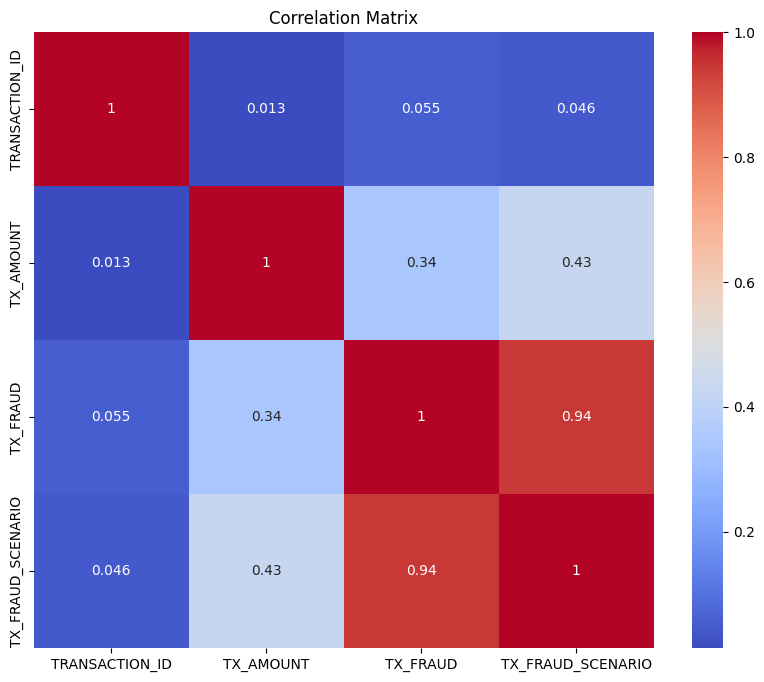

In [11]:
import seaborn as sns
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Convert the TX_DATETIME column to datetime format
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Extract relevant features from the timestamp
df['year'] = df['TX_DATETIME'].dt.year
df['month'] = df['TX_DATETIME'].dt.month
df['day'] = df['TX_DATETIME'].dt.day
df['hour'] = df['TX_DATETIME'].dt.hour
df['minute'] = df['TX_DATETIME'].dt.minute
df['second'] = df['TX_DATETIME'].dt.second

# Drop the original timestamp column
df.drop(columns=['TX_DATETIME'], inplace=True)

In [13]:
X = df.drop(columns=['TX_FRAUD'])
y = df['TX_FRAUD']

In [24]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1600, 13) (1600,)
Testing set shape: (400, 13) (400,)


In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def train_evaluate_MLP(X_train, y_train, X_test, y_test, hidden_layer_sizes=(100,), solver='adam', learning_rate_init=0.001):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, solver=solver, learning_rate_init=learning_rate_init, random_state=42)

    mlp.fit(X_train, y_train)

    y_pred = mlp.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

optimization_algorithms = ['adam', 'sgd']
learning_rates = [0.001, 0.01]

for solver in optimization_algorithms:
    for lr in learning_rates:
        accuracy = train_evaluate_MLP(X_train, y_train, X_test, y_test, solver=solver, learning_rate_init=lr)
        print(f"Solver: {solver}, Learning Rate: {lr}, Accuracy: {accuracy:.4f}")


Solver: adam, Learning Rate: 0.001, Accuracy: 0.4975
Solver: adam, Learning Rate: 0.01, Accuracy: 0.4975
Solver: sgd, Learning Rate: 0.001, Accuracy: 0.5025
Solver: sgd, Learning Rate: 0.01, Accuracy: 0.5025


In [28]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', learning_rate_init=0.001, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)

Accuracy: 0.4975
Precision: 0.5
Recall: 0.03482587064676617
F1-score: 0.06511627906976745
ROC-AUC: 0.4836870921773043


In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[192   7]
 [194   7]]


The model correctly predicted 192 instances of the positive class.
It incorrectly predicted 7 instances as positive when they were actually negative.
It incorrectly predicted 194 instances as negative when they were actually positive.
It correctly predicted 7 instances of the negative class.

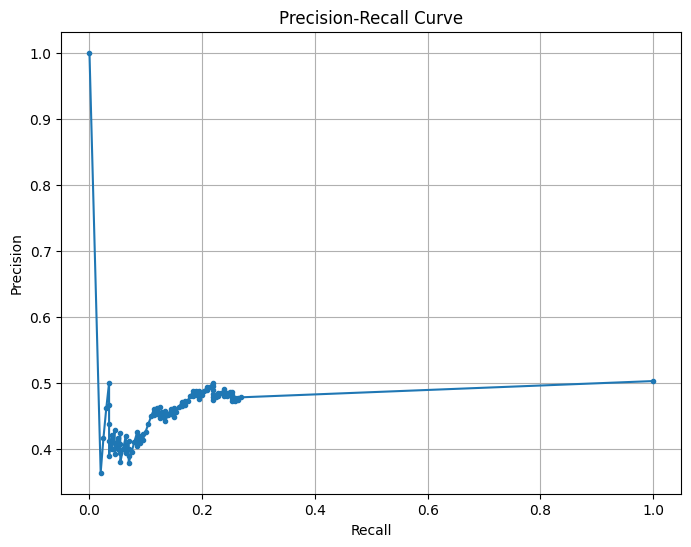

In [23]:
# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()